In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
import json
from pathlib import Path
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, accuracy_score
from sklearn.calibration import CalibrationDisplay

def get_prediction_results_filepaths(league: str, root: Path) -> tuple[list[Path], list[Path]]:
    predictions_path = root / league / "predictions"
    results_path = root / league / "results"

    results_files = list(results_path.glob("*.json"))
    prediction_files = [predictions_path / x.name for x in results_files if (predictions_path / x.name).exists()]

    return prediction_files, results_files

def make_dataframe(pred_filepaths: list[Path], res_filepaths: list[Path], total_line: float, hcp_line: float) -> pd.DataFrame:
    pred_df = (
        pd.DataFrame([json.load(path.open("r")) for path in pred_filepaths])
        .assign(
            ft_home_prob = lambda x: pd.json_normalize(x["preds"])["ft.home"]
        )
    )
    res_df = (
        pd.DataFrame([json.load(path.open("r")) for path in res_filepaths])
        .rename(
            columns={"home_team": "home_team_score", "away_team": "away_team_score"}
        )
    )

    totals = extract_prob_from_nested(df=pred_df, list_key="ou", key_field="points", key_value=total_line)
    hcps = extract_prob_from_nested(df=pred_df, list_key="hcp", key_field="hcp", key_value=hcp_line)
    
    pred_df = pred_df.join(totals).join(hcps)

    df = (
        pred_df
        .merge(res_df, on="match_id")
        .assign(
            ft_home_won=lambda x: x["home_team_score"] > x["away_team_score"],
            ou_won=lambda x: (x["home_team_score"] + x["away_team_score"]) > total_line,
            hcp_won=lambda x: ((x["home_team_score"] - x["away_team_score"]) + hcp_line) > 0,
        )
        .drop(columns=["preds"])
    )
    
    return df

def extract_prob_from_nested(
    df: pd.DataFrame, list_key: str, key_field: str, key_value: float, value_field: str = "prob"
) -> pd.Series:
    """
    From df["preds"][list_key] (list[dict]), pick the dict where dict[key_field] == key_value
    and return its value_field, aligned to the original index. NaN if missing.
    """
    def pick(p):
        items = (p or {}).get(list_key, [])

        for d in items:
            if d.get(key_field) == key_value:
                return d.get(value_field, np.nan)
        
        return np.nan

    return df["preds"].apply(pick).rename(f"{list_key}_prob")

def evaluate_calibration(
    df: pd.DataFrame,
    pairs = (
        ("ft_home_won", "ft_home_prob", "FT Home Win"),
        ("ou_won", "ou_prob", "Totals (Over/Under)"),
        ("hcp_won", "hcp_prob", "Asian Handicap"),
    ),
    n_bins: int = 20
) -> pd.DataFrame | None:

    def _safe_metrics(y_true: np.ndarray, p_pred: np.ndarray) -> dict[str, int | float]:
        p = np.clip(p_pred.astype(float), 1e-12, 1 - 1e-12)
        y = y_true.astype(int)

        metrics = {}
        metrics["n"] = y.shape[0]
        metrics["prevalence"] = y.mean()
        metrics["brier"] = brier_score_loss(y, p)
        metrics["logloss"] = log_loss(y, p)
        
        # in-case only one class
        try:
            metrics["auc"] = metrics["auc"] = roc_auc_score(y, p)
        except ValueError:
            metrics["auc"] = np.nan
        
        metrics["acc@0.5"] = accuracy_score(y, (p >= 0.5).astype(int))
        return metrics

    if df.shape[0] < 2:
        print("Not enough samples")
        return

    rows = []
    for y_col, p_col, label in pairs:
        rows.append({"metric": label, **_safe_metrics(df[y_col].values, df[p_col].values)})

    summary = (
        pd.DataFrame(rows)
        .set_index("metric")
        [["n", "prevalence", "brier", "logloss", "auc", "acc@0.5"]]
    )

    with pd.option_context("display.float_format", lambda v: f"{v:0.4f}"):
        print("=== Evaluation Summary ===")
        print(summary)

    cols = len(pairs)
    fig, axes = plt.subplots(1, cols, figsize=(6 * cols, 5), squeeze=False)
    axes = axes.ravel()

    for ax, (y, p, label) in zip(axes, pairs):
        CalibrationDisplay.from_predictions(df[y], df[p], n_bins=n_bins, ax=ax)
        ax.set_title(f"Calibration for {label}")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return summary


In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = get_prediction_results_filepaths(league="nhl", root=data_path)

df = make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=-1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020037,2025-10-12T02:00:00,Seattle Kraken,Vegas Golden Knights,0.4295,0.4842,0.2095,2,1,True,False,False
1,2025020052,2025-10-14T23:00:00,Washington Capitals,Tampa Bay Lightning,0.5160,0.4708,0.2778,3,2,True,False,False


=== Evaluation Summary ===
                      n  prevalence  brier  logloss    auc  acc@0.5
metric                                                             
FT Home Win          42      0.4524 0.2487   0.6898 0.5263   0.5000
Totals (Over/Under)  42      0.4524 0.2492   0.6916 0.4863   0.5952
Asian Handicap       42      0.2381 0.1773   0.5420 0.5687   0.7857


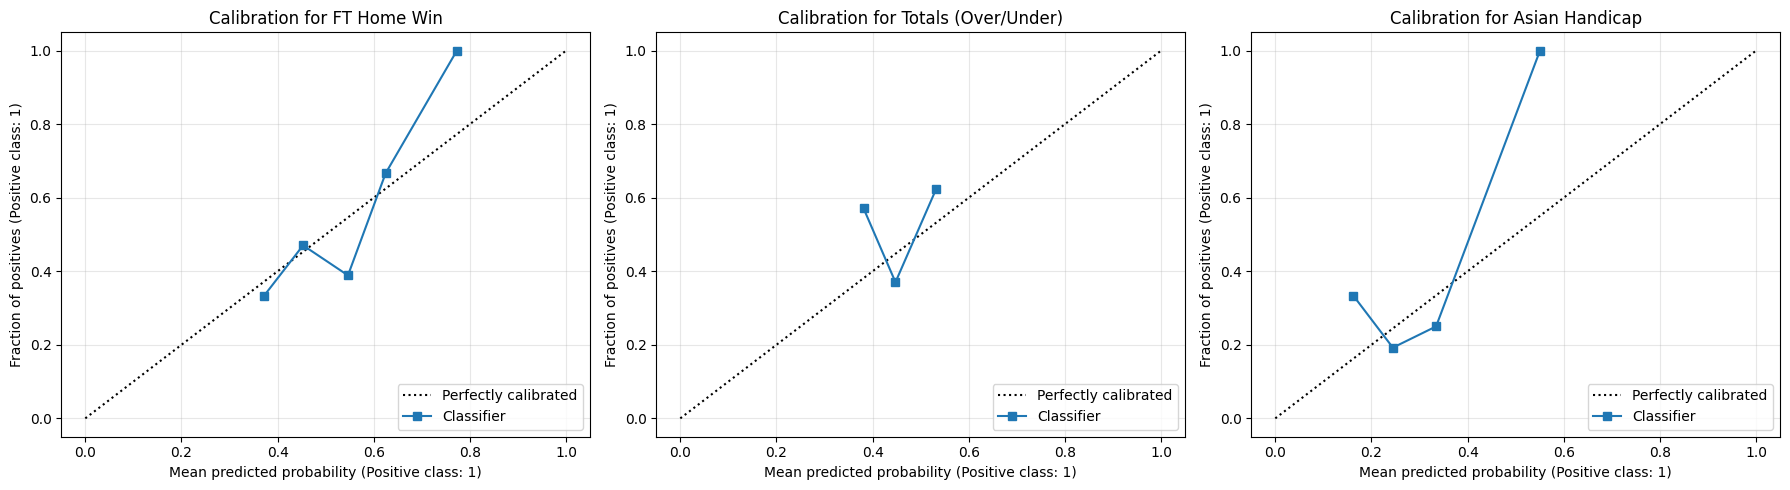

In [5]:
_ = evaluate_calibration(df=df, n_bins=10)

## NBA

In [ ]:
prediction_files, results_files = get_prediction_results_filepaths(league="nba", root=data_path)

df = make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=-8.5)
df.head(2)

In [ ]:
_ = evaluate_calibration(df=df, n_bins=10)

Not enough samples
